In [1]:
import os
import pandas as pd

def aggregate_pred_dataframe(files):
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

def aggregate_pred_with_prefix(prefix):
    csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
    csv_files.sort()
    len(csv_files)
    preds = []
    for seed in range(20):
        filtered = [file for file in csv_files if file.startswith(f'{prefix}_{seed}')]
        if filtered:
            preds.append((filtered[-1], filtered[-2]))
    
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds])
    
    return df_valid, df_test, preds

In [2]:
df_valid, df_test, preds = aggregate_pred_with_prefix('v002')

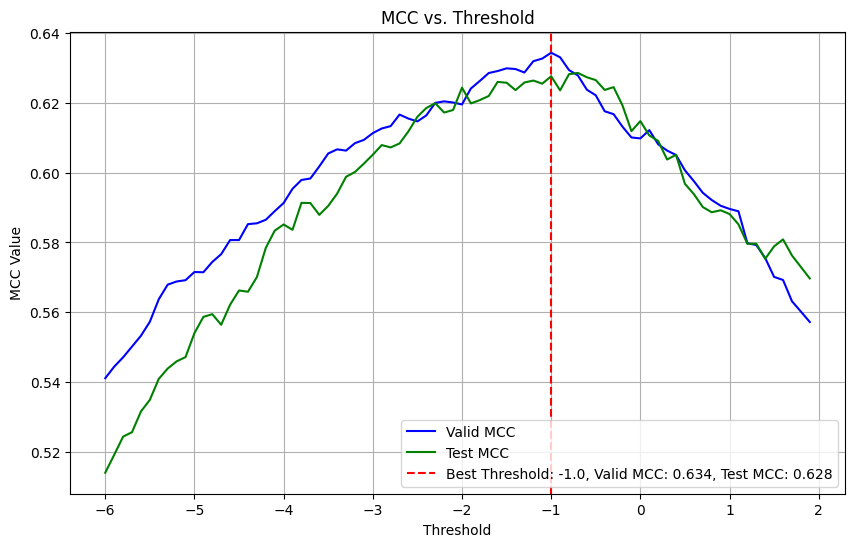

{'best_threshold': -1.0,
 'valid_mcc': 0.6344,
 'sensitivity': 0.5502,
 'specificity': 0.9902,
 'accuracy': 0.9674,
 'precision': 0.7533,
 'mcc': 0.6277}

In [3]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}

def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=0, end=30, plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, 0.1)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }

    
round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-4, end=2), 4)


In [4]:
# try n = 10 ensemble 10 times
from random import sample
df = pd.DataFrame()
for i in range(10):
    sample_preds = sample(preds, 10)
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])
    new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, plot=False)]
    new_df = pd.DataFrame(new_row)
    df = pd.concat([df, new_df], ignore_index=True)

df.aggregate(['mean', 'std']).T

,mean,std
best_threshold,-1.200000,0.397213
valid_mcc,0.628118,0.002798
sensitivity,0.563477,0.013023
specificity,0.988309,0.001105
accuracy,0.966306,0.000640
precision,0.725243,0.015504
mcc,0.622129,0.005734
